# SMR model (CMSR) v1
- Date: 23/01/2023
- Based on: https://www.kns.org/files/pre_paper/44/20A-079-김경원.pdf

Questions
1. Composition of Hastelloy N? Is it wo or ao? http://moltensalt.org/references/static/downloads/pdf/ORNL-TM-4189.pdf
1. Temperatures of fuel, moderator, cladding?

In [6]:
# Fuel properties
FUEL_TEMP = 900 # K
FUEL_ENRICHMENT = 4.0 # wo%
FUEL_R = 5 # cm

# Moderator properties
MODERATOR_TEMP = 900 # K

# Cladding properties
CLADDING_TEMP = 900 # K
CLADDING_R = 6 # cm

# Lattice properties
LATTICE_RINGS = 9
LATTICE_PITCH = 13 # cm

# Containment properties
CONTAINMENT_R = 120 # cm
CONTAINMENT_THICKNESS = 5 # cm -> total 125 cm radius, -> 250 cm diameter

# Core properties
CORE_HEIGHT = 200 # cm

In [7]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import os

# @@@@@@@@@@@@@@@@@@@@@@ Materials @@@@@@@@@@@@@@@@@@@@@@
# Fuel
# also set fuel color
material_fuel = openmc.Material(1, "NaF-KF-UF4", temperature=FUEL_TEMP)
material_fuel.add_elements_from_formula('NaFKFUF4', enrichment=FUEL_ENRICHMENT)
material_fuel.set_density('g/cm3', 4.261)
material_fuel.color = (0.8, 0.8, 0.8)

# Cladding
material_cladding = openmc.Material(2, "HastelloyN", temperature=CLADDING_TEMP)
material_cladding.add_element('Ni', 0.72, 'wo')
material_cladding.add_element('Mo', 0.16, 'wo')
material_cladding.add_element('Cr', 0.07, 'wo')
material_cladding.add_element('Cr', 0.05, 'wo')
material_cladding.set_density('g/cm3', 8.86)

# Moderator
material_moderator = openmc.Material(3, "NaOH", temperature=MODERATOR_TEMP)
material_moderator.add_elements_from_formula('NaOH')
material_moderator.set_density('g/cm3', 1.637)

# Create Materials list and export to XML
mats = openmc.Materials([material_fuel, material_cladding, material_moderator])
mats.export_to_xml()
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



# @@@@@@@@@@@@@@@@@@@@@@ Geometry @@@@@@@@@@@@@@@@@@@@@@
# Planes
plane_bottom = openmc.ZPlane(z0=-CORE_HEIGHT/2, boundary_type='vacuum')
plane_top = openmc.ZPlane(z0=CORE_HEIGHT/2, boundary_type='vacuum')

# Cylinders
r_pin = openmc.ZCylinder(r=FUEL_R)
r_cladding = openmc.ZCylinder(r=CLADDING_R)

# Regions
region_height_bound = +plane_bottom & -plane_top
region_fuel = -r_pin & region_height_bound
region_cladding = +r_pin & -r_cladding & region_height_bound
region_moderator = +r_cladding & region_height_bound

# Cells
cell_fuel = openmc.Cell(name="fuel", fill=material_fuel, region=region_fuel)
cell_cladding = openmc.Cell(name="cladding", fill=material_cladding, region=region_cladding)
cell_moderator = openmc.Cell(name="moderator", fill=material_moderator, region=region_moderator)

# Universe
universe_pin = openmc.Universe(cells=(cell_fuel, cell_cladding, cell_moderator))

# Outer universe
cell_all_moderator = openmc.Cell(name="outer", fill=material_moderator)
universe_outer = openmc.Universe(cells=(cell_all_moderator,))
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



# @@@@@@@@@@@@@@@@@@@@@@ Lattice @@@@@@@@@@@@@@@@@@@@@@
lattice = openmc.HexLattice()
lattice.center = (0., 0.)
lattice.pitch = (LATTICE_PITCH,)
lattice.outer = universe_outer
lattice.orientation = 'x' # With orientation 'x', the lattice is rotated 90 degrees

universes = [[universe_pin]*(6*i + (i==0)*1) for i in range(LATTICE_RINGS)[::-1]]

# Add another outer lattice ring with 4 pin cells on each side of the hexagon
# This function picks out 4 cells on each side of the hexagon
def condition_on_ring(i):
    return 2 < i % LATTICE_RINGS < 7
if LATTICE_RINGS != 9:
    raise Exception("LATTICE_RINGS must be 9 - otherwise, change the condition above")
universes.insert(0, [universe_pin if condition_on_ring(i) else universe_outer for i in range(6*(LATTICE_RINGS))])

lattice.universes = universes

plane_containment_bottom = openmc.ZPlane(z0=-CORE_HEIGHT/2+CONTAINMENT_THICKNESS, boundary_type='vacuum')
plane_containment_top = openmc.ZPlane(z0=CORE_HEIGHT/2-CONTAINMENT_THICKNESS, boundary_type='vacuum')
r_containment_inner = openmc.ZCylinder(r=CONTAINMENT_R)
r_containment_outer = openmc.ZCylinder(r=CONTAINMENT_R+CONTAINMENT_THICKNESS, boundary_type='vacuum')

bottom_slab = +plane_bottom & -plane_containment_bottom
top_slab = -plane_top & +plane_containment_top
region_height_bound_inner = +plane_containment_bottom & -plane_containment_top
region_containment = (+r_containment_inner & -r_containment_outer & region_height_bound) | (-r_containment_inner & (bottom_slab | top_slab))

cell_containment = openmc.Cell(name="containment", fill=material_cladding, region=region_containment)
cell_main = openmc.Cell(fill=lattice, region=(-r_containment_inner & region_height_bound_inner))
geometry = openmc.Geometry([cell_containment, cell_main])
geometry.export_to_xml()
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

/Users/sigge/opt/anaconda3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/Users/sigge/opt/anaconda3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/Users/sigge/opt/anaconda3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


In [8]:
# print(lattice.show_indices(num_rings=LATTICE_RINGS))
# print(lattice)

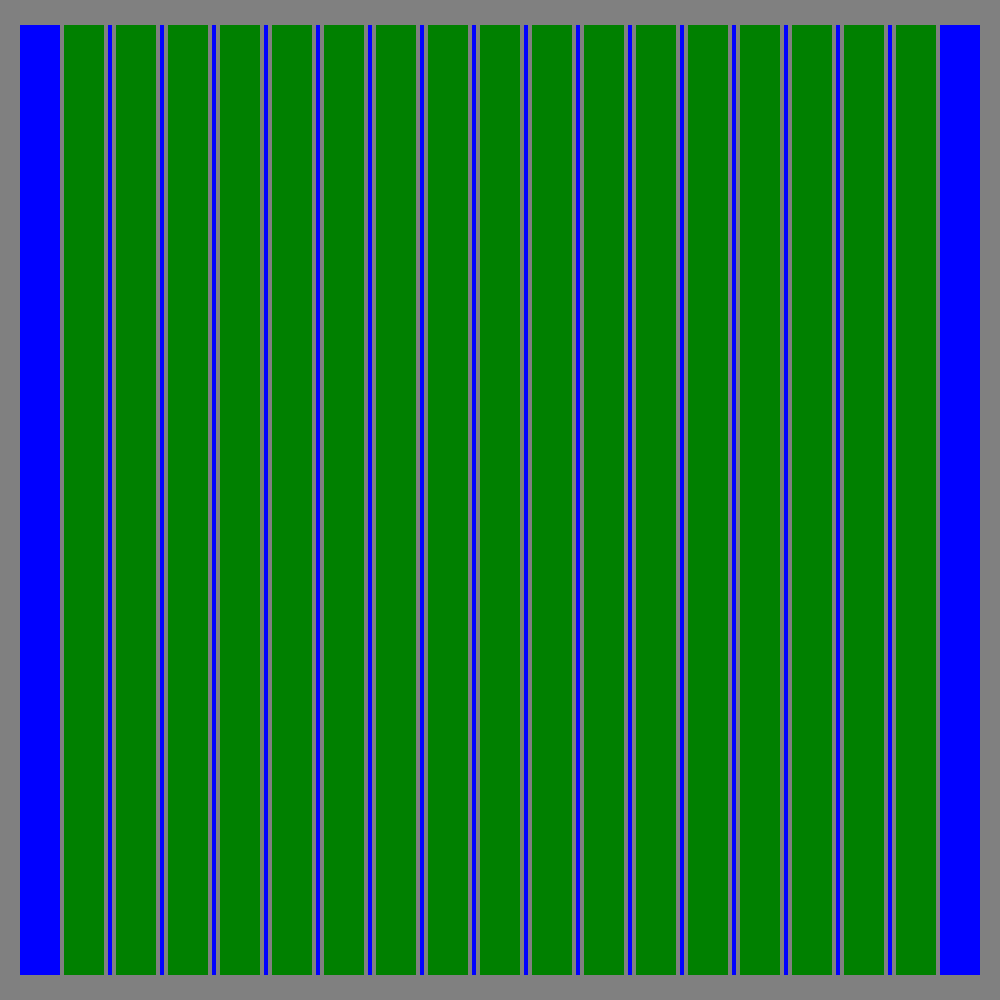

In [12]:
# @@@@@@@@@@@@@@@@@@@@@@ Plots @@@@@@@@@@@@@@@@@@@@@@

PLOT_COLOR_BY = 'material'
PLOT_PIXELS = (1000, 1000)
PLOT_FUEL_COLOR = 'green'
PLOT_CLADDING_COLOR = 'gray'
PLOT_MODERATOR_COLOR = 'blue'

colors = {
    material_fuel: PLOT_FUEL_COLOR,
    material_cladding: PLOT_CLADDING_COLOR,
    material_moderator: PLOT_MODERATOR_COLOR
}

plotXY = openmc.Plot.from_geometry(geometry, basis='xy')
plotXY.color_by = PLOT_COLOR_BY
plotXY.filename = 'plotXY'
plotXY.pixels = PLOT_PIXELS
plotXY.colors = colors
plotXY.to_ipython_image()

plotXZ = openmc.Plot.from_geometry(geometry, basis='xz')
plotXZ.color_by = PLOT_COLOR_BY
plotXZ.filename = 'plotXZ'
plotXZ.pixels = PLOT_PIXELS
plotXZ.colors = colors
plotXZ.to_ipython_image()


# plots = openmc.Plots([plot])
# plots.export_to_xml()
# set xlabel of plot

# vox_plot = openmc.Plot()
# vox_plot.type = 'voxel'
# vox_plot.width = (100., 100., 50.)
# vox_plot.pixels = (400, 400, 200)
# vox_plot.to_ipython_image()
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
